# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

!pip install pyLDAvis==3.4.1 --user

#You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0

In [6]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\earne\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


True

In [7]:
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [ ]:
# add any additional libaries you need here



In [8]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [9]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [10]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [11]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

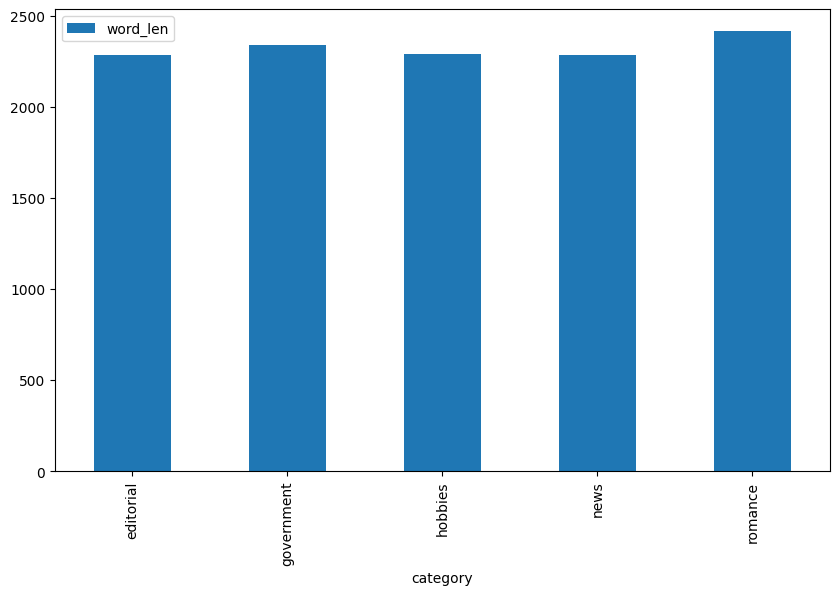

In [16]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [17]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\earne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [18]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The 'count_text_vectors' data frame is a representation of frequency of each word in a document.  The rows will represent the documents, the columns represent words that occure in the corpus, and each cell represents a count of how many times each word occurs in a document.  The "tfidf_text_vectors' data frame, on the other hand, doesn't just accout for how often a word occures, but also attempts to account for the importance of the word across all of the documents.  It will assign more importance to a word that occurs frequently in one document, but rarely across the entire corpus of documents.  

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [19]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [20]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [21]:
# Your code here
# The W Matrix holds the topics as the columns and the documents as rows
# we can use this to combine it with the original dataframe that has the category and id

w_matrix_df = pd.DataFrame(W_text_matrix)
w_matrix_df["category"] = df["category"]
w_matrix_df["id"] = df["id"]


topic_dictionary = dict()

topic_dictionary = {0 : {},
                    1 : {},
                    2 : {},
                    3 : {},
                    4 : {}}

# Looping over the dataframe (using .iterrows())
for index, row in w_matrix_df.iterrows():
    
    # in order to get the Topic we extract the first 5 values of each row
    # then using .argsort() we find the indexes based on size of each value
    # then we inverse sort from highest to lowest
    # and the document topic is the first of the highest --> largest value is the Topic that document belongs to
    document_topic = np.array(row.iloc[0:5]).argsort()[::-1][0]
    
    # now that we access to that doc category, we can just select it
    document_category = row['category'] 
    
    # building the dictionary
    if document_category in topic_dictionary[document_topic]:
        topic_dictionary[document_topic][document_category] += 1
    else:
        topic_dictionary[document_topic][document_category] = 1


# once dictionary is created, we loop over it to get
# the print out of how many categories per Topic
for key, dictionary_value in topic_dictionary.items():
    
    print(f"\nTopic {key}:")
    
    for category in dictionary_value:
        
        print(f"  {dictionary_value[category]} {category}") 


Topic 0:
  20 editorial
  4 government
  8 news

Topic 1:
  4 editorial
  29 romance
  8 hobbies

Topic 2:
  2 editorial
  26 government
  11 news
  26 hobbies

Topic 3:
  17 news
  1 hobbies

Topic 4:
  1 editorial
  8 news
  1 hobbies


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: It is not far off.  It makes sense there would be some difficulty distinguishing between news, editorial, and government.  It did a fairly decent job figuring out editorial was topic 0.  Topic 1 was clearly romance.  Topic 2 is where we see confusion between government and hobbies.  The NMF seemed to struggle with hobbies, and it should have included these 26 articles in topic 4.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [22]:
# Your code here
svd_para_model = TruncatedSVD(n_components = 5, random_state=314)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

In [23]:
# tallying the Brown categories

w_svd_matrix_df = pd.DataFrame(W_svd_para_matrix)
w_svd_matrix_df["category"] = df["category"]
w_svd_matrix_df["id"] = df["id"]
                       
topic_dictionary = dict()

topic_dictionary = {0 : {}, 1 : {}, 2 : {}, 3 : {}, 4 : {}}

for index, row in w_svd_matrix_df.iterrows():
    document_topic = np.array(row.iloc[0:5]).argsort()[::-1][0]
    document_category = row['category'] 

    if document_category in topic_dictionary[document_topic]:
        topic_dictionary[document_topic][document_category] += 1
    else:
        topic_dictionary[document_topic][document_category] = 1

for key, dictionary_value in topic_dictionary.items():
    print(f"\nTopic {key}:")
    for category in dictionary_value:
        print(f"  {dictionary_value[category]} {category}") 
        




Topic 0:
  27 editorial
  30 government
  34 news
  21 romance
  36 hobbies

Topic 1:
  8 romance

Topic 2:

Topic 3:
  3 news

Topic 4:
  7 news


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model was not able to find the original Brown corpus categories as well as the NMF model did.  It assigned almost all of the articles to topic 0, and left topic 2 with nothing.  

In [24]:
# call display_topics on your model
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: Aside from topic 4, many of the words driving the topics are much different for the LSA model than the NMF.  For example, topic 2 has many of the words that were included in topic 0 of the NMF model.  

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [25]:
# Fit your LDA model here
lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=314)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

In [26]:
# Call `display_topics` on your fitted model here
display_topics(lda_para_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


In [27]:
# tallying the Brown categories

w_lda_matrix_df = pd.DataFrame(W_lda_para_matrix)
w_lda_matrix_df["category"] = df["category"]
w_lda_matrix_df["id"] = df["id"]
                       
topic_dictionary = dict()

topic_dictionary = {0 : {}, 1 : {}, 2 : {}, 3 : {}, 4 : {}}

for index, row in w_lda_matrix_df.iterrows():
    document_topic = np.array(row.iloc[0:5]).argsort()[::-1][0]
    document_category = row['category'] 

    if document_category in topic_dictionary[document_topic]:
        topic_dictionary[document_topic][document_category] += 1
    else:
        topic_dictionary[document_topic][document_category] = 1

for key, dictionary_value in topic_dictionary.items():
    print(f"\nTopic {key}:")
    for category in dictionary_value:
        print(f"  {dictionary_value[category]} {category}") 


Topic 0:
  3 editorial
  1 government
  4 news
  28 romance
  11 hobbies

Topic 1:
  1 editorial
  12 government
  3 news
  9 hobbies

Topic 2:
  21 editorial
  3 government
  32 news
  1 romance
  2 hobbies

Topic 3:
  2 editorial
  4 government
  3 news
  8 hobbies

Topic 4:
  10 government
  2 news
  6 hobbies


Q: What inference do you draw from the displayed topics for your LDA model? 

A: It's clear that changing to a focus on word frequency vs importance has impacted the main words in each topic.  We see the word "000" in topic 1, but it clearly has little to do with any topic, it just happens to show up frequently in these doucments.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: It seems to do fairly well finding the news and romance topics, but struggles with the others.

In [29]:
lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [30]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The PCA scatterplot suggests there isn't any overlap between them, with topics 4 and 2 being probably the most closely related.  This plot also gives us the relative size of the topics, with 3 and 1 being the largest.  The bar chart gives us infomration on the word distrubution for each topic.  A rapidly decreasing word distribution suggests a well pronounced topic, where as a slowly decreasing distribution suggests a less prounounced topic.  Topics 3 and 5 are the most pronounced topics, while 4 is the least. 
